In [ ]:
import cv2
from io import BytesIO
from PIL import Image
import requests
import numpy as np
import scipy as sp
from scipy.fftpack import fft, ifft
import zipfile
import os
import matplotlib.pyplot as plt
from io import BytesIO
import requests

In [ ]:
zip_path = '/content/Dataset-Shapes.zip'
extract_dir = '/content'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
ruta_imagen_butterfly = '/content/Dataset-Shapes/butterfly/butterfly-1.png'
ruta_imagen_children = '/content/Dataset-Shapes/children/children-1.png'

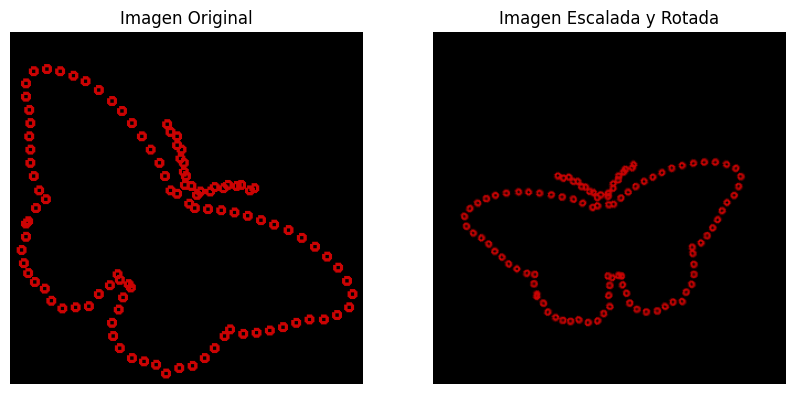

In [ ]:
def imagen_escalar_rotar(image_path, scale_factor=1.0, angle=0, save_path=None):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("La imagen no se pudo cargar. Verifica la ruta y el nombre del archivo.")

    (h, w) = image.shape[:2]

    nuevo_w = int(w * scale_factor)
    nuevo_h = int(h * scale_factor)
    imagen_escalda = cv2.resize(image, (nuevo_w, nuevo_h))

    diagonal = int(np.sqrt(nuevo_w**2 + nuevo_h**2))
    nuevo_tamaño = (diagonal, diagonal)

    nuevo_centro = (diagonal // 2, diagonal // 2)

    translation_matrix = np.array([[1, 0, nuevo_centro[0] - nuevo_w // 2], [0, 1, nuevo_centro[1] - nuevo_h // 2]], dtype=np.float32)
    imagen_centrada = cv2.warpAffine(imagen_escalda, translation_matrix, nuevo_tamaño)

    M = cv2.getRotationMatrix2D(nuevo_centro, angle, 1.0)
    imagen_rotado = cv2.warpAffine(imagen_centrada, M, nuevo_tamaño)

    if guardar_ruta:
        cv2.imwrite(guardar_ruta, imagen_rotado)

    return imagen_rotado

guardar_ruta = '/content/butterfly_escalado_rotado.png'

imagen_escalar_rotar = imagen_escalar_rotar(ruta_imagen_butterfly, scale_factor=0.7, angle=45, save_path=guardar_ruta)

imagen_original = cv2.imread(ruta_imagen_butterfly)
imagen_original_rgb = cv2.cvtColor(imagen_original, cv2.COLOR_BGR2RGB)
imagen_escalado_rotado_rgb = cv2.cvtColor(imagen_escalar_rotar, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(imagen_original_rgb)
plt.title('Imagen Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(imagen_escalado_rotado_rgb)
plt.title('Imagen Escalada y Rotada')
plt.axis('off')

plt.show()


In [ ]:
ruta_butterfly_escalado_rotado = '/content/butterfly_escalado_rotado.png'

def contorno_centroide_figura(image_path, title_prefix):
    image = cv2.imread(image_path)

    if image is None:
        raise ValueError("La imagen no se pudo cargar. Verifica la ruta y el nombre del archivo.")

    imagen_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(imagen_rgb, cv2.COLOR_RGB2GRAY)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)

    contornos, jerarquia = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    area_min = 1000
    contornos_filtrados = [cnt for cnt in contornos if cv2.contourArea(cnt) > area_min]
    img_bordes = cv2.Canny(gray, 50, 150, apertureSize=3)

    img_contornos = np.zeros_like(imagen_rgb)
    if len(contornos_filtrados) > 0:
        max_contour = max(contornos_filtrados, key=cv2.contourArea)
        cv2.drawContours(img_contornos, [max_contour], -1, (0, 255, 0), 2)
        M = cv2.moments(max_contour)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            cv2.circle(img_contornos, (cx, cy), 5, (0, 0, 255), -1)
            print(f"Centroide en: ({cx}, {cy})")
        else:
            print("No se pudo calcular el centroide correctamente (división por cero).")
    else:
        print("No se encontraron contornos.")

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

    axes[0, 0].imshow(imagen_rgb)
    axes[0, 0].axis('off')
    axes[0, 0].set_title('Imagen Original')

    axes[0, 1].imshow(gray, cmap='gray')
    axes[0, 1].axis('off')
    axes[0, 1].set_title('Imagen en escala de grises')

    axes[1, 0].imshow(img_bordes, cmap='gray')
    axes[1, 0].axis('off')
    axes[1, 0].set_title('Bordes')

    axes[1, 1].imshow(img_contornos)
    axes[1, 1].axis('off')
    axes[1, 1].set_title('Contorno y Centroide')

    plt.show()


Centroide en: (132, 185)


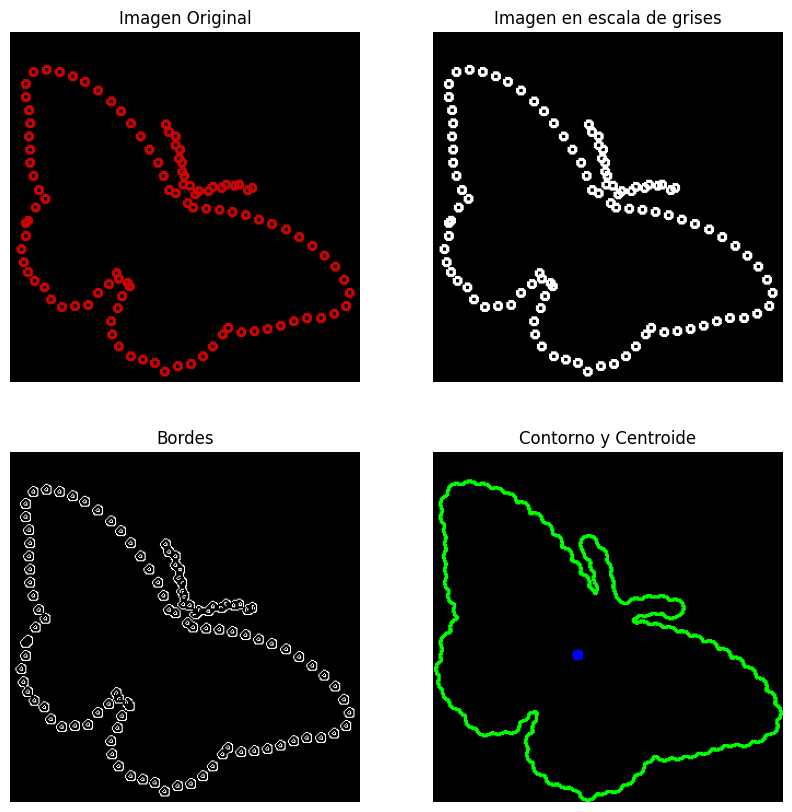

Centroide en: (60, 156)


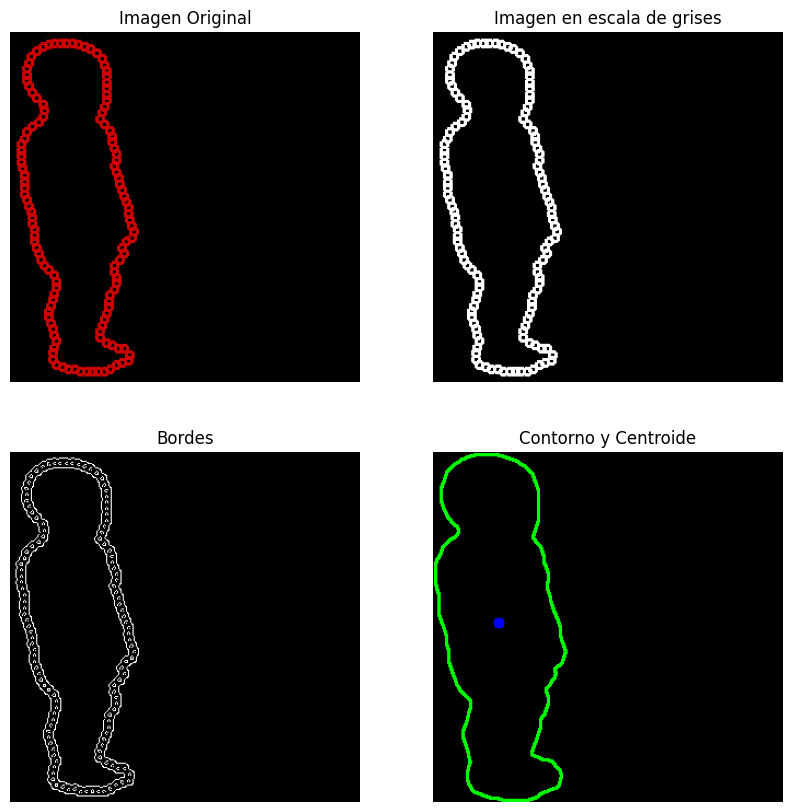

Centroide en: (156, 183)


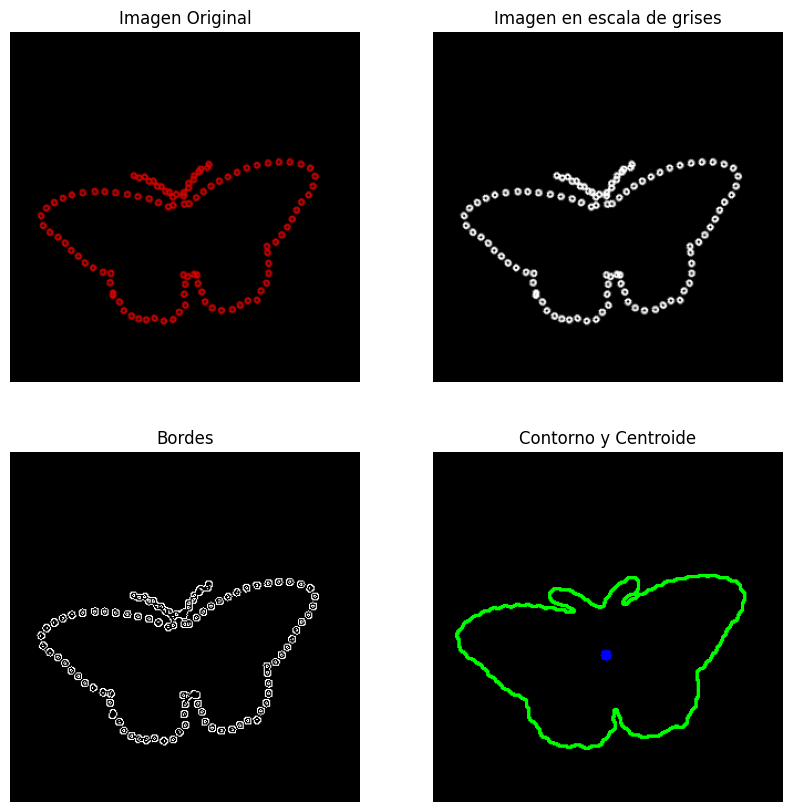

In [ ]:
contorno_centroide_figura(ruta_imagen_butterfly, 'Butterfly')
contorno_centroide_figura(ruta_imagen_children, 'Children')
contorno_centroide_figura(ruta_butterfly_escalado_rotado, 'Butterfly Esclada y Rotada')

In [ ]:
def obtener_distancia(contor, centroide):
    distancia = np.sqrt((contor[0][0] - centroide[0])**2 + (contor[0][1] - centroide[1])**2)
    return distancia

def firma_forma(image_path, title_prefix):
    image = cv2.imread(image_path)

    if image is None:
        raise ValueError("La imagen no se pudo cargar. Verifica la ruta y el nombre del archivo.")

    imagen_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(imagen_rgb, cv2.COLOR_RGB2GRAY)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    contornos, jerarquia = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    area_min = 1000
    contornos_filtrados = [cnt for cnt in contornos if cv2.contourArea(cnt) > area_min]

    img_bordes = cv2.Canny(gray, 50, 150, apertureSize=3)

    img_contornos = np.zeros_like(imagen_rgb)
    if len(contornos_filtrados) > 0:
        max_contour = max(contornos_filtrados, key=cv2.contourArea)
        cv2.drawContours(img_contornos, [max_contour], -1, (0, 255, 0), 2)
        M = cv2.moments(max_contour)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            centroide = (cx, cy)
            cv2.circle(img_contornos, (cx, cy), 5, (0, 0, 255), -1)
            print(f"Centroide en: ({cx}, {cy})")

            distancias = [obtener_distancia(pt, centroide) for pt in max_contour]

            ix = np.arange(0, len(distancias), 1)
            plt.figure(figsize=(10, 5))
            plt.plot(ix, distancias, lw=0.7)
            plt.title(f'Firma de la Forma - {title_prefix}')
            plt.xlabel('Punto del Contorno')
            plt.ylabel('Distancia al Centroide')
            plt.grid(True)
            plt.show()
        else:
            print("No se pudo calcular el centroide correctamente (división por cero).")
    else:
        print("No se encontraron contornos.")


Centroide en: (132, 185)


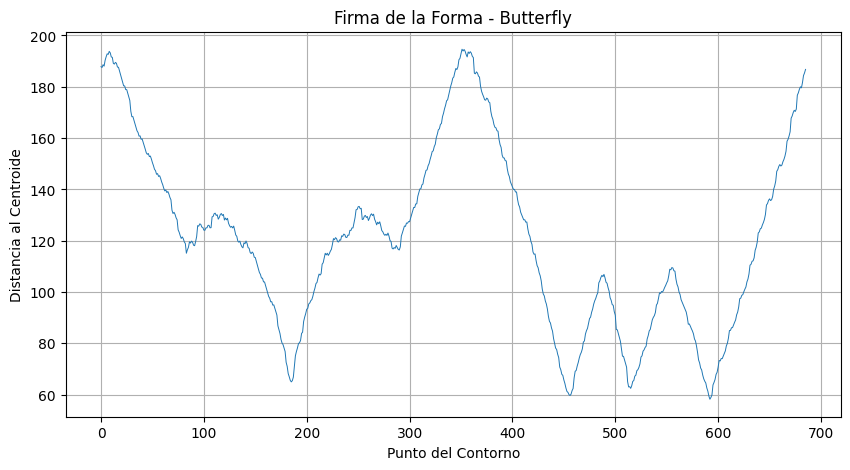

Centroide en: (156, 183)


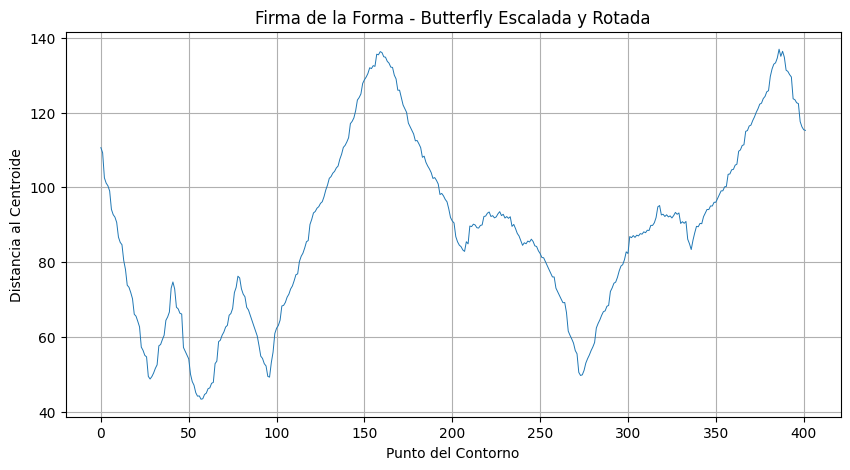

In [ ]:
firma_forma(ruta_imagen_butterfly, 'Butterfly')
firma_forma(ruta_butterfly_escalado_rotado, 'Butterfly Escalada y Rotada')

Centroide en: (132, 185)


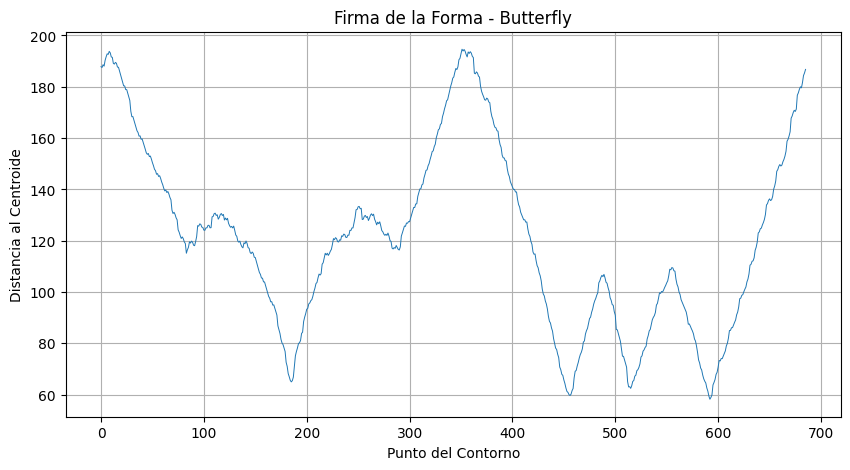

Centroide en: (60, 156)


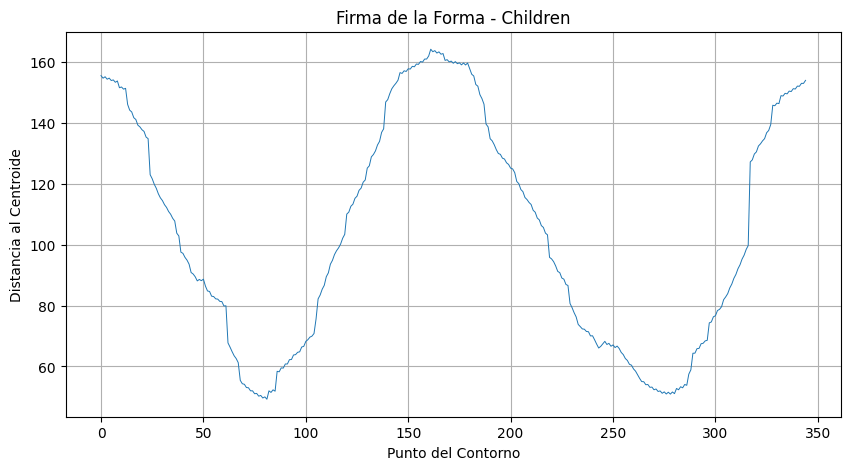

In [ ]:
firma_forma(ruta_imagen_butterfly, 'Butterfly')
firma_forma(ruta_imagen_children, 'Children')


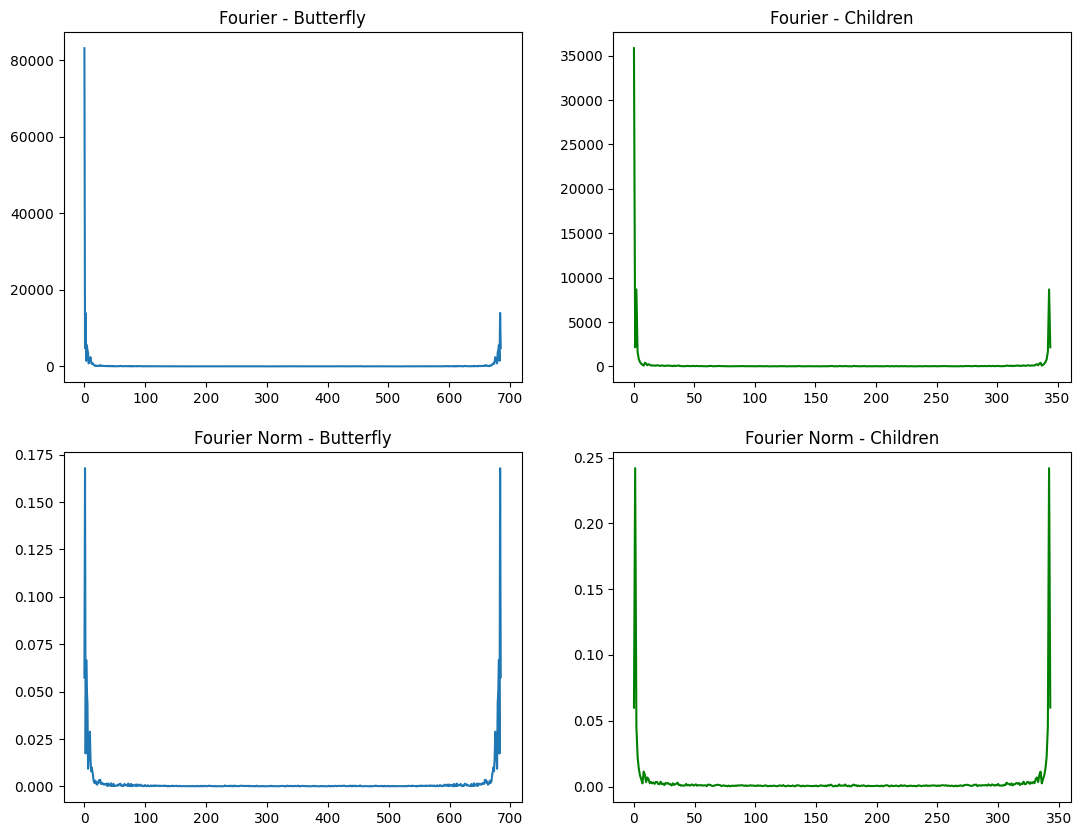

Distancia entre Butterfly y Children: (0.25839115014038905-0.017530793651539672j)


In [ ]:
def distancias_imgs(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("La imagen no se pudo cargar. Verifica la ruta y el nombre del archivo.")

    imagen_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(imagen_rgb, cv2.COLOR_RGB2GRAY)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    contornos, jerarquia = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    area_min = 1000
    contornos_filtrados = [cnt for cnt in contornos if cv2.contourArea(cnt) > area_min]

    if len(contornos_filtrados) > 0:
        max_contour = max(contornos_filtrados, key=cv2.contourArea)
        M = cv2.moments(max_contour)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            centroide = (cx, cy)
            distancias = [obtener_distancia(pt, centroide) for pt in max_contour]
            return distancias
        else:
            raise ValueError("No se pudo calcular el centroide correctamente (división por cero).")
    else:
        raise ValueError("No se encontraron contornos.")

def distancia(dis1, dis2):
    dis = 0.0
    for i in range(min(len(dis1), len(dis2))):
        dis += (dis1[i] - dis2[i])**2
    return np.sqrt(dis)

distancias_butterfly = distancias_imgs(ruta_imagen_butterfly)
distancias_children = distancias_imgs(ruta_imagen_children)
distancias_escalado_butterfly = distancias_imgs(ruta_butterfly_escalado_rotado)

fourier_butterfly = fft(distancias_butterfly)
fourier_children = fft(distancias_children)
fourier_escalado_butterfly = fft(distancias_escalado_butterfly)

fourier_butterfly_N = fourier_butterfly / fourier_butterfly[0]
fourier_children_N = fourier_children / fourier_children[0]
fourier_escalado_butterfly_N = fourier_scaled_butterfly / fourier_escalado_butterfly[0]

figure, axes = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(13, 10)

axes[0, 0].plot(np.abs(fourier_butterfly))
axes[0, 0].set_title('Fourier - Butterfly')

axes[0, 1].plot(np.abs(fourier_children), color='green')
axes[0, 1].set_title('Fourier - Children')

axes[1, 0].plot(np.abs(fourier_butterfly_N[1:]))
axes[1, 0].set_title('Fourier Norm - Butterfly')

axes[1, 1].plot(np.abs(fourier_children_N[1:]), color='green')
axes[1, 1].set_title('Fourier Norm - Children')

plt.show()

distancia_butterfly_children = distancia(fourier_butterfly_N, fourier_children_N)
print('Distancia entre Butterfly y Children:', distancia_butterfly_children)

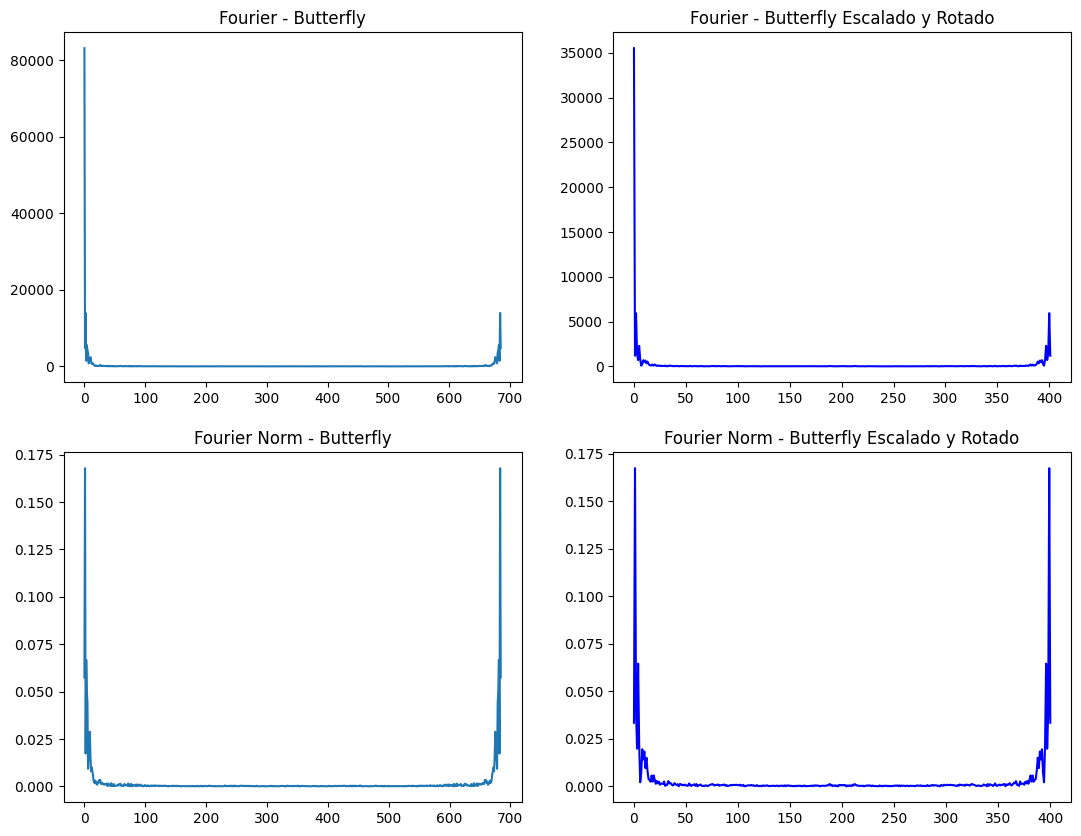

Distancia entre Butterfly y Butterfly Escalada y Rotada: (0.13877240190812423-0.2463066800145596j)


In [ ]:
figure, axes = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(13, 10)

axes[0, 0].plot(np.abs(fourier_butterfly))
axes[0, 0].set_title('Fourier - Butterfly')

axes[0, 1].plot(np.abs(fourier_escalado_butterfly), color='blue')
axes[0, 1].set_title('Fourier - Butterfly Escalado y Rotado')

axes[1, 0].plot(np.abs(fourier_butterfly_N[1:]))
axes[1, 0].set_title('Fourier Norm - Butterfly')

axes[1, 1].plot(np.abs(fourier_escalado_butterfly_N[1:]), color='blue')
axes[1, 1].set_title('Fourier Norm - Butterfly Escalado y Rotado')

plt.show()

distancia_butterfly_escalado_butterfly = distancia(fourier_butterfly_N, fourier_escalado_butterfly_N)
print('Distancia entre Butterfly y Butterfly Escalada y Rotada:', distancia_butterfly_escalado_butterfly)
